In [1]:
import os
import sys
import pandas as pd
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())) + "/..")
if os.getcwd().endswith("Topic1"):
    os.chdir("..")
    print(f"Changed to {os.getcwd()}")
from codebase import get_total_inhabitants_and_willingness

Changed to c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation


In [2]:
within_mins = 50
punt = "hbo_wo" # ibis, hbo_wo, mbo, basis, highschool, bus, trein
mode = "fiets" # fiets, ebike
location = "Universities" # Elementary Schools, High Schools, Universities, Train - NS, Train - Local

total, total_willing = get_total_inhabitants_and_willingness(punt1=punt, mode=mode, within_mins=within_mins, location=location, verbose=True)

Loaded file from CSV
Total inhabitants within 50 minutes of hbo_wo from buurt: 9843955 of 17811291 = 55.27% of the Netherlands
Total willingness to cycle of those: 3655316 of 9843955 = 37.13%


<Figure size 1000x1000 with 0 Axes>

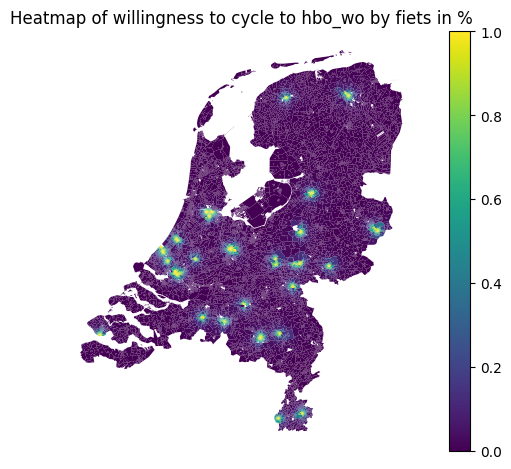

In [3]:
from codebase import plot_willingness_heatmap

plot_willingness_heatmap(punt, mode, location, savename=f"graphics/nl_maps/{punt}_by_{mode}.png")